<a href="https://colab.research.google.com/github/Fharuk/DATATALKS-2025-COHORT/blob/main/DataTalks_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import roc_auc_score

numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in numerical_features:
    auc = roc_auc_score(y_train, X_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    auc_scores[col] = auc

highest_auc_feature = max(auc_scores, key=auc_scores.get)

print("AUC scores for numerical features:")
for col, auc in auc_scores.items():
    print(f"{col}: {auc:.4f}")

print(f"\nNumerical variable with the highest AUC: {highest_auc_feature}")

AUC scores for numerical features:
lead_score: 0.6111
number_of_courses_viewed: 0.7652
interaction_count: 0.7272
annual_income: 0.5446

Numerical variable with the highest AUC: number_of_courses_viewed


In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [ ]:
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].fillna(0.0)

display(df.isnull().sum())

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('converted', axis=1)
y = df['converted']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (877, 8)
Validation set shape: (292, 8)
Test set shape: (293, 8)


In [7]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
print("Categorical features:", categorical_features)

Categorical features: ['lead_source', 'industry', 'employment_status', 'location']


In [8]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train_dict = X_train[categorical_features].to_dict(orient='records')
X_val_dict = X_val[categorical_features].to_dict(orient='records')

X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

print("Shape of encoded training data:", X_train_encoded.shape)
print("Shape of encoded validation data:", X_val_encoded.shape)

Shape of encoded training data: (877, 27)
Shape of encoded validation data: (292, 27)


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [10]:
y_pred = model.predict_proba(X_val_encoded)[:, 1]

In [11]:
from sklearn.metrics import roc_auc_score

auc_val = roc_auc_score(y_val, y_pred)
rounded_auc_val = round(auc_val, 3)

print(f"ROC AUC on validation set: {rounded_auc_val}")

ROC AUC on validation set: 0.636


In [12]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = []
precisions = []
recalls = []

threshold_values = np.arange(0.0, 1.01, 0.01)

for threshold in threshold_values:
    thresholds.append(threshold)

In [14]:
for threshold in threshold_values:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    precisions.append(precision)
    recalls.append(recall)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

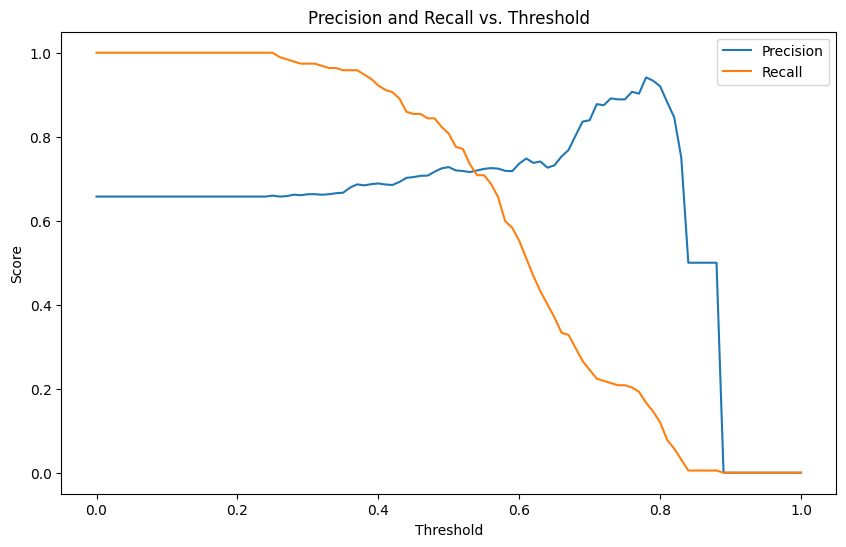

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [16]:
min_diff = float('inf')
intersection_threshold = None

for i in range(len(thresholds)):
    diff = abs(precisions[i] - recalls[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresholds[i]

print(f"Approximate intersection threshold: {intersection_threshold}")

Approximate intersection threshold: 0.89


In [17]:
print(f"The calculated AUC rounded to 3 decimal places is: {rounded_auc_val}")
print(f"The approximate intersection threshold is: {intersection_threshold}")

The calculated AUC rounded to 3 decimal places is: 0.636
The approximate intersection threshold is: 0.89


In [18]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

In [19]:
f1_scores = []
threshold_values = np.arange(0.0, 1.01, 0.01)

for threshold in threshold_values:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)

In [20]:
from sklearn.metrics import f1_score

for threshold in threshold_values:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_binary)
    f1_scores.append(f1)

In [21]:
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = threshold_values[max_f1_index]

print(f"The threshold with the maximal F1 score is: {max_f1_threshold:.2f}")

The threshold with the maximal F1 score is: 0.37


In [22]:
print(f"The threshold with the maximal F1 score is: {max_f1_threshold:.2f}")

The threshold with the maximal F1 score is: 0.37


In [23]:
print(f"The threshold with the maximal F1 score is: {max_f1_threshold:.2f}")

The threshold with the maximal F1 score is: 0.37


In [24]:
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

print(f"Shape of combined features: {X_full_train.shape}")
print(f"Shape of combined target: {y_full_train.shape}")

Shape of combined features: (1169, 8)
Shape of combined target: (1169,)


In [25]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [26]:
auc_scores_cv = []

for train_idx, val_idx in kfold.split(X_full_train):
    pass # This loop will be completed in subsequent steps

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

for train_idx, val_idx in kfold.split(X_full_train):
    X_train_fold = X_full_train.iloc[train_idx]
    y_train_fold = y_full_train.iloc[train_idx]
    X_val_fold = X_full_train.iloc[val_idx]
    y_val_fold = y_full_train.iloc[val_idx]

    dv = DictVectorizer(sparse=False)

    X_train_dict_fold = X_train_fold[categorical_features].to_dict(orient='records')
    X_val_dict_fold = X_val_fold[categorical_features].to_dict(orient='records')

    X_train_encoded_fold = dv.fit_transform(X_train_dict_fold)
    X_val_encoded_fold = dv.transform(X_val_dict_fold)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded_fold, y_train_fold)

    y_pred_proba_fold = model.predict_proba(X_val_encoded_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
    auc_scores_cv.append(auc_fold)

In [28]:
import numpy as np

std_auc_cv = np.std(auc_scores_cv)
print(f"Standard deviation of AUC scores across folds: {std_auc_cv:.3f}")

Standard deviation of AUC scores across folds: 0.042


In [29]:
print(f"The standard deviation of the AUC scores across folds is: {std_auc_cv:.3f}")

The standard deviation of the AUC scores across folds is: 0.042


**Reasoning**:
Import KFold and create a KFold object as specified.



In [31]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

## Initialize results storage

### Subtask:
Create dictionaries or lists to store the mean AUC scores and standard deviations for each `C` value.


**Reasoning**:
Initialize empty dictionaries to store the mean AUC and standard deviation of AUC for each C value.



In [32]:
mean_auc_per_c = {}
std_auc_per_c = {}

## Iterate through c values

### Subtask:
Loop through each `C` value in the defined list.


**Reasoning**:
Iterate through the defined C values and initialize a list to store AUC scores for each C.



In [33]:
for C in c_values:
    auc_scores_for_c = []
    # The rest of the cross-validation loop will be in subsequent steps

**Reasoning**:
Perform cross-validation for the current C value.



In [34]:
for C in c_values:
    auc_scores_for_c = []
    for train_idx, val_idx in kfold.split(X_full_train):
        X_train_fold = X_full_train.iloc[train_idx]
        y_train_fold = y_full_train.iloc[train_idx]
        X_val_fold = X_full_train.iloc[val_idx]
        y_val_fold = y_full_train.iloc[val_idx]

        dv = DictVectorizer(sparse=False)

        X_train_dict_fold = X_train_fold[categorical_features].to_dict(orient='records')
        X_val_dict_fold = X_val_fold[categorical_features].to_dict(orient='records')

        X_train_encoded_fold = dv.fit_transform(X_train_dict_fold)
        X_val_encoded_fold = dv.transform(X_val_dict_fold)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded_fold, y_train_fold)

        y_pred_proba_fold = model.predict_proba(X_val_encoded_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        auc_scores_for_c.append(auc_fold)
    # Mean and std calculation will be in the next step

**Reasoning**:
Calculate the mean and standard deviation of the AUC scores for the current C value and store them in the dictionaries.



In [35]:
for C in c_values:
    auc_scores_for_c = []
    for train_idx, val_idx in kfold.split(X_full_train):
        X_train_fold = X_full_train.iloc[train_idx]
        y_train_fold = y_full_train.iloc[train_idx]
        X_val_fold = X_full_train.iloc[val_idx]
        y_val_fold = y_full_train.iloc[val_idx]

        dv = DictVectorizer(sparse=False)

        X_train_dict_fold = X_train_fold[categorical_features].to_dict(orient='records')
        X_val_dict_fold = X_val_fold[categorical_features].to_dict(orient='records')

        X_train_encoded_fold = dv.fit_transform(X_train_dict_fold)
        X_val_encoded_fold = dv.transform(X_val_dict_fold)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded_fold, y_train_fold)

        y_pred_proba_fold = model.predict_proba(X_val_encoded_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        auc_scores_for_c.append(auc_fold)

    mean_auc = np.mean(auc_scores_for_c)
    std_auc = np.std(auc_scores_for_c)

    mean_auc_per_c[C] = round(mean_auc, 3)
    std_auc_per_c[C] = round(std_auc, 3)

print("Mean AUC per C:", mean_auc_per_c)
print("Standard deviation of AUC per C:", std_auc_per_c)

Mean AUC per C: {1e-06: np.float64(0.639), 0.001: np.float64(0.64), 1.0: np.float64(0.642)}
Standard deviation of AUC per C: {1e-06: np.float64(0.038), 0.001: np.float64(0.037), 1.0: np.float64(0.042)}


**Reasoning**:
Find the C value with the best mean AUC, using standard deviation and smallest C as tie-breaking rules.



In [36]:
best_c = None
best_mean_auc = -1
best_std_auc = float('inf')

for C in c_values:
    current_mean_auc = mean_auc_per_c[C]
    current_std_auc = std_auc_per_c[C]

    if current_mean_auc > best_mean_auc:
        best_mean_auc = current_mean_auc
        best_std_auc = current_std_auc
        best_c = C
    elif current_mean_auc == best_mean_auc:
        if current_std_auc < best_std_auc:
            best_std_auc = current_std_auc
            best_c = C
        elif current_std_auc == best_std_auc:
            if C < best_c:
                best_c = C

print(f"The best C value is: {best_c}")

The best C value is: 1.0


## Answer the question

### Subtask:
Answer the question


**Reasoning**:
Print the best C value, its corresponding mean AUC, and standard deviation, then finish the task.



In [37]:
print(f"The best C value is: {best_c}")
print(f"The corresponding mean AUC is: {best_mean_auc:.3f}")
print(f"The corresponding standard deviation of AUC is: {best_std_auc:.3f}")

The best C value is: 1.0
The corresponding mean AUC is: 0.642
The corresponding standard deviation of AUC is: 0.042
